This file only shows augmentation examples 

In [1]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 5.7MB/s 


In [2]:
import os
import sys
import time

from google.colab import drive

drive.mount('/content/drive')
IMAGES_DIR = '/content/drive/My Drive/Neural/dataset/stage_2_train_images'
LABELS_CSV_TMP = '/content/drive/My Drive/Neural/dataset/stage_2_train_labels.csv'
CLASS_INFO_CSV = '/content/drive/My Drive/Neural/dataset/stage_2_detailed_class_info.csv'

print(IMAGES_DIR)
print(LABELS_CSV_TMP)
print(CLASS_INFO_CSV)

Mounted at /content/drive
/content/drive/My Drive/Neural/dataset/stage_2_train_images
/content/drive/My Drive/Neural/dataset/stage_2_train_labels.csv
/content/drive/My Drive/Neural/dataset/stage_2_detailed_class_info.csv


## Custom Dataset definition

Let's increase the data for each bouinding box with 'x_max' and 'y_max', in order to adopt the Pascal standard format

In [3]:
import pandas as pd
import numpy as np

labels_csv = pd.read_csv(LABELS_CSV_TMP, )

# fill empty labels (class 0) with all 0
labels_csv.x.fillna(0, inplace=True)
labels_csv.y.fillna(0, inplace=True)
labels_csv.width.fillna(0, inplace=True)
labels_csv.height.fillna(0, inplace=True)

# add Pascal bounding boxes encoding
labels_csv['x_max'] = labels_csv['x']+labels_csv['width']
labels_csv['y_max'] = labels_csv['y']+labels_csv['height']

labels_csv.sample(10)

patientId      x      y  ...  Target  x_max  y_max
27117  f135d126-5a13-44ed-bb30-3334cbc2b7f2    0.0    0.0  ...       0    0.0    0.0
24855  df1179b1-ff4d-4f34-9768-a4abccea5f8b    0.0    0.0  ...       0    0.0    0.0
22088  c801ebd5-8032-473d-8a47-de337f59c904  530.0  273.0  ...       1  774.0  622.0
4844   41bf80a8-621d-4efd-8559-db86626c28dc    0.0    0.0  ...       0    0.0    0.0
24264  d9f7cfdf-0b34-4647-bd4c-5f64d21f717a    0.0    0.0  ...       0    0.0    0.0
13761  89b98f9a-d4e7-4234-a047-2e3874155181  220.0  127.0  ...       1  440.0  749.0
9984   6ba9800e-ebf3-4fd4-9fa7-1022883c4f21  266.0  308.0  ...       1  490.0  581.0
3526   38e68dfa-d76e-4d4a-9fa8-4a9d86f1a380    0.0    0.0  ...       0    0.0    0.0
23895  d6ef3c16-9f2e-4ebd-b106-0d1f61cc3ad4    0.0    0.0  ...       0    0.0    0.0
10455  6f3953f5-5129-4a74-b8f9-cf386f919930  142.0  425.0  ...       1  379.0  740.0

[10 rows x 8 columns]

Let's define the different types of augmentations

In [4]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def augmentation_pipeline(level):
  if level == 'resize_only':
    list_augmentations = [
      iaa.Resize(512)            
    ]

  elif level == 'light':
    list_augmentations = [
      iaa.Resize(512),
      iaa.Affine(
        scale=1.1, 
        shear=(2.5,2.5), 
        rotate=(-5, 5), 
      ),    
    ]
    
  elif level == 'heavy': #no rotation included
    list_augmentations = [
      iaa.Resize(512),
      iaa.Affine(
        scale=1.15, 
        shear=(4.0,4.0),
      ),   
      iaa.Fliplr(0.2), # horizontally flip 20% of the images
      iaa.Sometimes(0.1, iaa.CoarseSaltAndPepper(p=(0.01, 0.01), size_percent=(0.1, 0.2))),
      iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0))),
      iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.04 * 255))),            
           
    ]

  elif level == 'heavy_with_rotations':
    list_augmentations = [
      iaa.Resize(512),
      iaa.Affine(
        scale=1.15, 
        shear=(4.0,4.0),
        rotate=(-6, 6), 
      ),   
      iaa.Fliplr(0.2), # horizontally flip 20% of the images
      iaa.Sometimes(0.1, iaa.CoarseSaltAndPepper(p=(0.01, 0.01), size_percent=(0.1, 0.2))),
      iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0))),
      iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.04 * 255))),            
    ]

  return list_augmentations

Let's define the custom dataset class 

In [5]:
from torch.utils.data import Dataset
import torch
import pydicom

def get_image_array(image_path):
  try:
    dcm_data = pydicom.read_file(image_path)
    img = dcm_data.pixel_array
    return img
  except:
      pass

def parse_one_annot(box_coord, filename):
  boxes_array = box_coord[box_coord["patientId"] == filename][["x", "y", "x_max", "y_max"]].values
  return boxes_array 

In [6]:
class CXRimages(Dataset):
    def __init__(self, csv_file, images_dir, augmentations='resize_only', transform=None):
      self.path = images_dir      
      self.annotations = csv_file
      self.augmentations = augmentation_pipeline(augmentations)    # augmentations with imgaug
      self.transform = transform                                   # Images ToTensor and normalize
      self.imgs = sorted(os.listdir(images_dir))


    def num_classes(self):
      return 3


    def __len__(self):
      return len(self.annotations)


    def __getitem__(self, idx):   #requires to define new indexes from 0
        patient_id = self.annotations['patientId'][idx]

        # load image
        img_path = os.path.join(self.path, patient_id +'.dcm')
        img = get_image_array(img_path) # only in case we are loading the dicom images directly

        # get bounding boxes from csv
        box_list = parse_one_annot(self.annotations, patient_id)
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)

        # imgaug transform box encoding
        list_boxes = []
        for j in range(num_objs):
          list_boxes.append(BoundingBox(x1=boxes[j][0].item(), x2=boxes[j][2].item(), y1=boxes[j][1].item(), y2=boxes[j][3].item()))
        bbs = BoundingBoxesOnImage(list_boxes, shape=img.shape)

        # augmentation
        seq_training = iaa.Sequential(self.augmentations)
        image_aug, bbs_aug = seq_training(image=img, bounding_boxes=bbs) 

        # get back to tensor boxes ancoding
        box_list = []
        for box in bbs_aug.bounding_boxes:
          box_list.append([box.x1, box.y1, box.x2, box.y2])

        bbs_aug = torch.as_tensor(box_list, dtype=torch.float32)

        # set the box labels depending on patient label
        if len(torch.nonzero(boxes)) > 0:
          labels = torch.ones((num_objs,), dtype=torch.int64)
        else:
          labels = torch.zeros((num_objs,), dtype=torch.int64)

        # extra information for standard torchvision format 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # set metadata
        target = {}
        target["boxes"] = bbs_aug
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["patient_id"] = patient_id 

        if self.transform is not None:
                image_aug = self.transform(image_aug.copy())  # .copy() avoid negative values in tensor

        return image_aug, target

## Split Train + Validation dataset

Let's split dataset as: 
*   training => 80%
*   validation/test => 20%
  - validation => 50%
  - test => 50%
  
  

In [7]:
np.random.seed(13)
msk = np.random.rand(len(labels_csv)) < 0.8

# split train and val/test + add indexes from 0 as required by class definition
train_df = labels_csv[msk].reset_index()  
val_train_df = labels_csv[~msk]

# aplit val/test
split_val = int(len(val_train_df)/2)
val_df = val_train_df.iloc[:split_val,:].reset_index()
test_df = val_train_df.iloc[split_val:,:].reset_index()

print(f'Samples in train set: {len(train_df)} \nSamples in validation set: {len(val_df)} \nSamples in test set: {len(val_df)} \n')

Samples in train set: 24085 
Samples in validation set: 3071 
Samples in test set: 3071 



In [8]:
train_df[:10]

index                             patientId      x  ...  Target  x_max  y_max
0      0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0  ...       0    0.0    0.0
1      1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0  ...       0    0.0    0.0
2      5  00436515-870c-4b36-a041-de91049b9ab4  562.0  ...       1  818.0  605.0
3      6  00569f44-917d-4c86-a842-81832af98c30    0.0  ...       0    0.0    0.0
4      7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    0.0  ...       0    0.0    0.0
5      8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  ...       1  483.0  681.0
6      9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  ...       1  857.0  712.0
7     10  008c19e8-a820-403a-930a-bc74a4053664    0.0  ...       0    0.0    0.0
8     11  009482dc-3db5-48d4-8580-5c89c4f01334    0.0  ...       0    0.0    0.0
9     12  009eb222-eabc-4150-8121-d5a6d06b8ebf    0.0  ...       0    0.0    0.0

[10 rows x 9 columns]

In [9]:
val_df[:10]

index                             patientId      x  ...  Target  x_max  y_max
0      2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0  ...       0    0.0    0.0
1      3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0  ...       0    0.0    0.0
2      4  00436515-870c-4b36-a041-de91049b9ab4  264.0  ...       1  477.0  531.0
3     13  00a85be6-6eb0-421d-8acf-ff2dc0007e8a    0.0  ...       0    0.0    0.0
4     20  00f08de1-517e-4652-a04f-d1dc9ee48593  571.0  ...       1  801.0  751.0
5     23  01027bc3-dc40-4165-a6c3-d6be2cb7ca34    0.0  ...       0    0.0    0.0
6     27  012a5620-d082-4bb8-9b3b-e72d8938000c  133.0  ...       1  408.0  888.0
7     30  01538c3b-3de9-4fbb-95a8-732235821bbf    0.0  ...       0    0.0    0.0
8     35  019ca122-9cdf-4704-b7a9-449c8a1c263e    0.0  ...       0    0.0    0.0
9     42  01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce  609.0  ...       1  845.0  640.0

[10 rows x 9 columns]

In [10]:
test_df[:10]

index                             patientId      x  ...  Target  x_max  y_max
0  15088  93e36af8-ab53-487d-a486-3d0e0476bb84    0.0  ...       0    0.0    0.0
1  15090  93e82b8f-b78d-45d5-84ce-a21e6ae5cc3d    0.0  ...       0    0.0    0.0
2  15092  93eb36cf-5356-4be3-b740-1c4d7a842741  579.0  ...       1  765.0  599.0
3  15094  93efbaea-b85e-4c07-bb97-4f8e92442405    0.0  ...       0    0.0    0.0
4  15095  93f035f7-32f7-44f6-8d9a-3fe67b03fe10    0.0  ...       0    0.0    0.0
5  15100  93fa8cf3-124a-4d7e-a06d-a0d836831e0a    0.0  ...       0    0.0    0.0
6  15104  9405a1ba-63e1-4c5e-9430-4952d1d27496    0.0  ...       0    0.0    0.0
7  15110  94211273-5b21-47fa-bbe0-7496e66672ac  185.0  ...       1  397.0  867.0
8  15121  94399962-8f89-4dfa-a93f-7a3df88feca5  305.0  ...       1  509.0  652.0
9  15123  943b27f1-ba1c-415b-b738-7b52aefa445b    0.0  ...       0    0.0    0.0

[10 rows x 9 columns]

## Show samples - resized only

Remember we can set 4 differnt type of augmentation, that are

- 'resize_only'
- 'light'
- 'heavy'
- 'heavy_with_rotations'

In [12]:
import torchvision.transforms as T

def To_tensor_tfms():
   transforms = []
   transforms.append(T.ToTensor())
   return T.Compose(transforms)

train_dataset = CXRimages(csv_file = train_df , images_dir = IMAGES_DIR, augmentations='resize_only', transform = To_tensor_tfms())

val_dataset = CXRimages(csv_file = val_df , images_dir = IMAGES_DIR, augmentations='resize_only', transform = To_tensor_tfms())
test_dataset = CXRimages(csv_file = test_df , images_dir = IMAGES_DIR, augmentations='resize_only', transform = To_tensor_tfms())

print(f'Samples in train set: {len(train_dataset)} \nSamples in validation set: {len(val_dataset)} \nSamples in test set: {len(test_dataset)}')

Samples in train set: 24085 
Samples in validation set: 3071 
Samples in test set: 3071


Let's show an example of custom dataset object

In [13]:
train_dataset.__getitem__(5)

(tensor([[[0.2157, 0.1373, 0.0745,  ..., 0.0078, 0.0078, 0.0000],
          [0.2118, 0.1373, 0.0706,  ..., 0.0078, 0.0078, 0.0000],
          [0.2078, 0.1333, 0.0706,  ..., 0.0078, 0.0078, 0.0000],
          ...,
          [0.3020, 0.2431, 0.2000,  ..., 0.0863, 0.1098, 0.0902],
          [0.3529, 0.3059, 0.2667,  ..., 0.1137, 0.1412, 0.1176],
          [0.4431, 0.3961, 0.3569,  ..., 0.1451, 0.1804, 0.1569]]]),
 {'area': tensor([16640., 22194.]),
  'boxes': tensor([[161.5000, 288.5000, 241.5000, 340.5000],
          [347.5000, 287.5000, 428.5000, 356.0000]]),
  'image_id': tensor([5]),
  'iscrowd': tensor([0, 0]),
  'labels': tensor([1, 1]),
  'patient_id': '00704310-78a8-4b38-8475-49f4573b2dbb'})

Let's plot some example images

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [15]:
def print_samples_with_boxes(dataset, idx_start = 0):

  # initalize variables for loop
  grid, gridx = plt.subplots(4,4, figsize=(22,25))
  old_patient_id = -1     # impossible value for a patient_id
  dataframe_counter = idx_start  # index refering to position in dataframe
  img_index = 0           # index refering to image position inside grid
  

  while img_index < 16:
    dataframe_counter += 1 

    # retrieve data
    data = dataset.__getitem__(dataframe_counter)
    patient_id = data[1]['patient_id']

    # check if it is new image, otherwise just skip
    if patient_id == old_patient_id:
      continue

    # other data needed
    image = data[0]
    boxes = data[1]['boxes']
    target = data[1]['labels'][0].item()

    # initialize image plot
    img = np.squeeze(image)
    gridx[img_index//4, img_index%4].set_title(patient_id)
    gridx[img_index//4, img_index%4].imshow(img)

    # bounding boxes (might be more for one pic)
    for j in range(len(boxes)):
      x1 = boxes[j][0]
      y1 = boxes[j][1]
      x2 = boxes[j][2]
      y2 = boxes[j][3]
      gridx[img_index//4, img_index%4].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none'))

    # this is needed to avoid showing duplicates in case of more bounding boxes
    old_patient_id = patient_id
    img_index += 1

  plt.show()

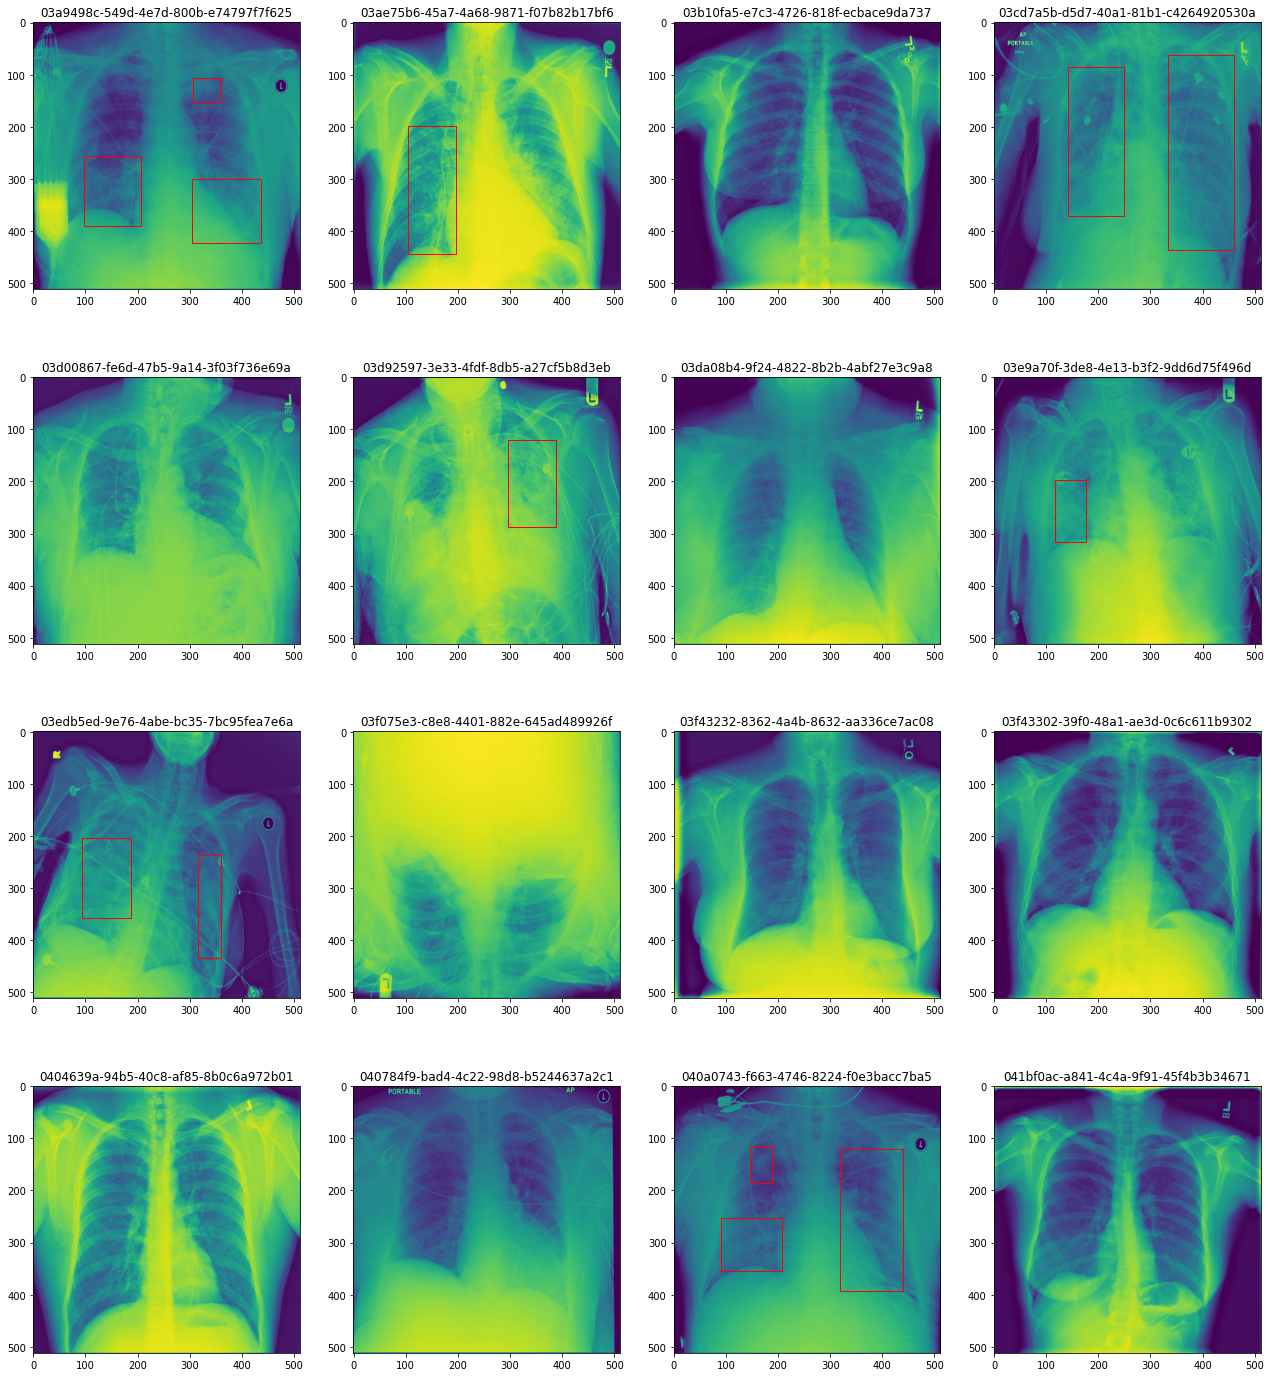

In [16]:
print_samples_with_boxes(train_dataset, 100)

## Augmentation test - heavy with rotations

In [17]:
import torchvision.transforms as T

def To_tensor_tfms():
   transforms = []
   transforms.append(T.ToTensor())
   return T.Compose(transforms)

train_dataset = CXRimages(csv_file = train_df , images_dir = IMAGES_DIR, augmentations='heavy_with_rotations', transform = To_tensor_tfms())

val_dataset = CXRimages(csv_file = val_df , images_dir = IMAGES_DIR, augmentations='resize_only', transform = To_tensor_tfms())
test_dataset = CXRimages(csv_file = test_df , images_dir = IMAGES_DIR, augmentations='resize_only', transform = To_tensor_tfms())

print(f'Samples in train set: {len(train_dataset)} \nSamples in validation set: {len(val_dataset)} \nSamples in test set: {len(test_dataset)}')

Samples in train set: 24085 
Samples in validation set: 3071 
Samples in test set: 3071


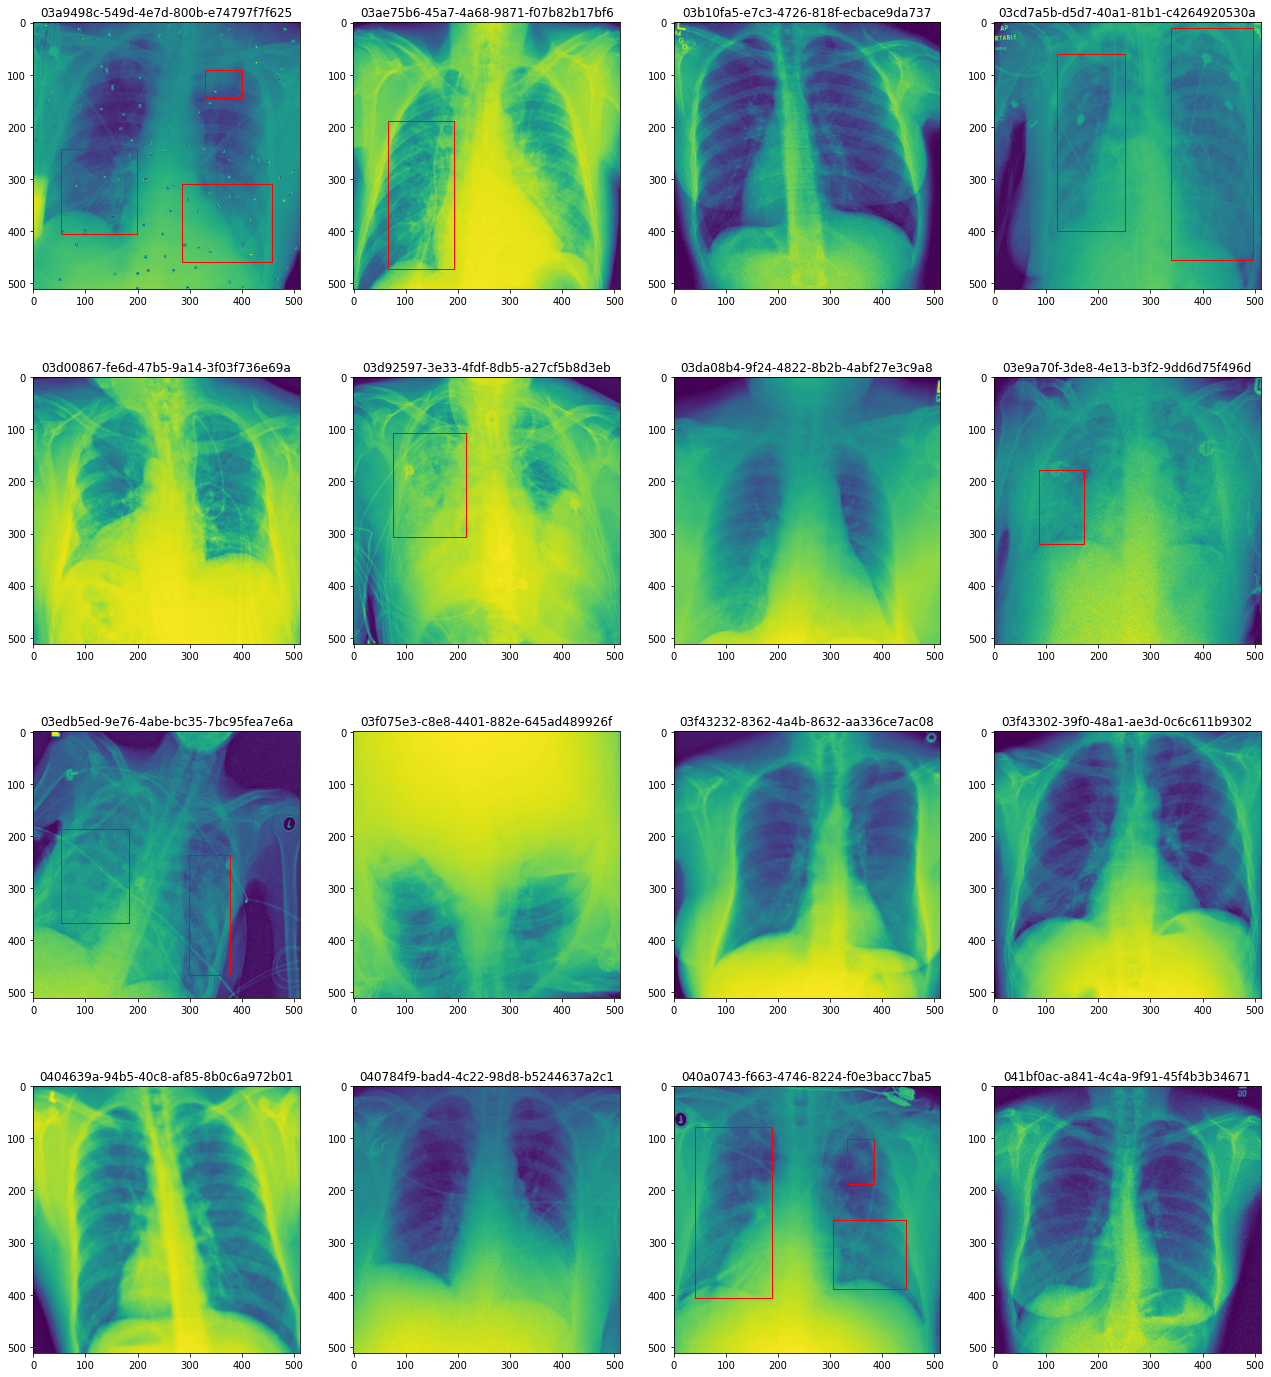

In [18]:
print_samples_with_boxes(train_dataset, 100)

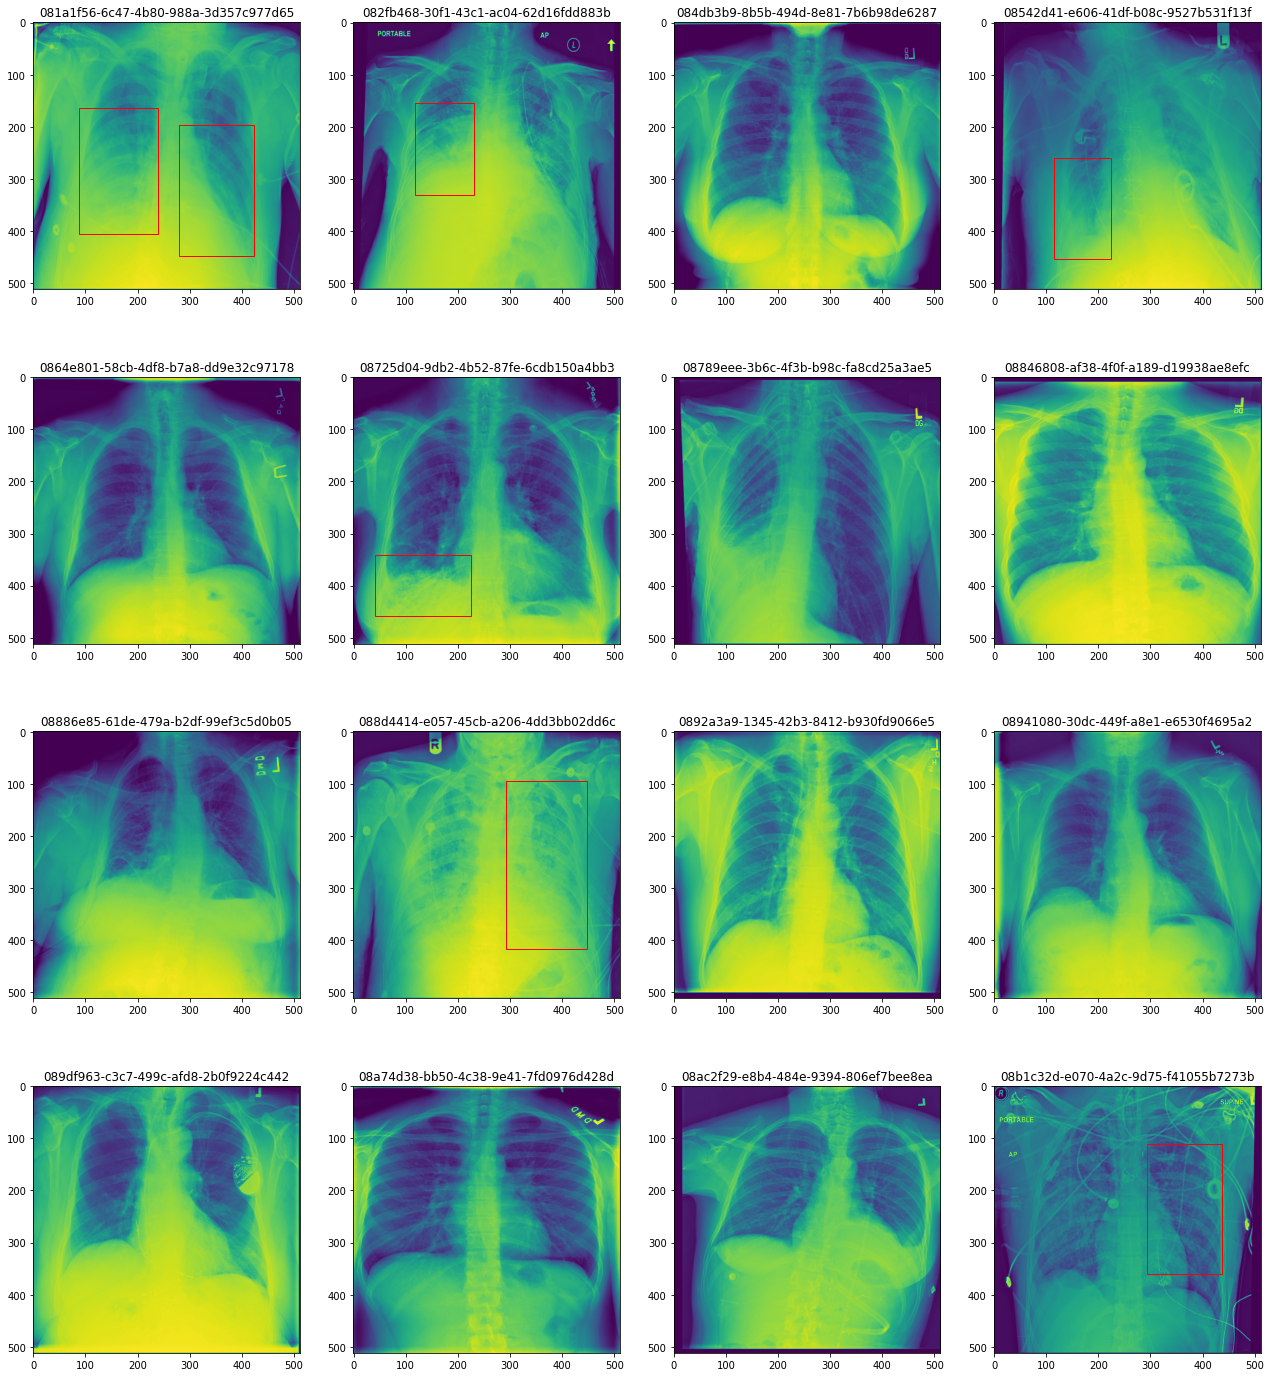

In [19]:
print_samples_with_boxes(val_dataset, 100)

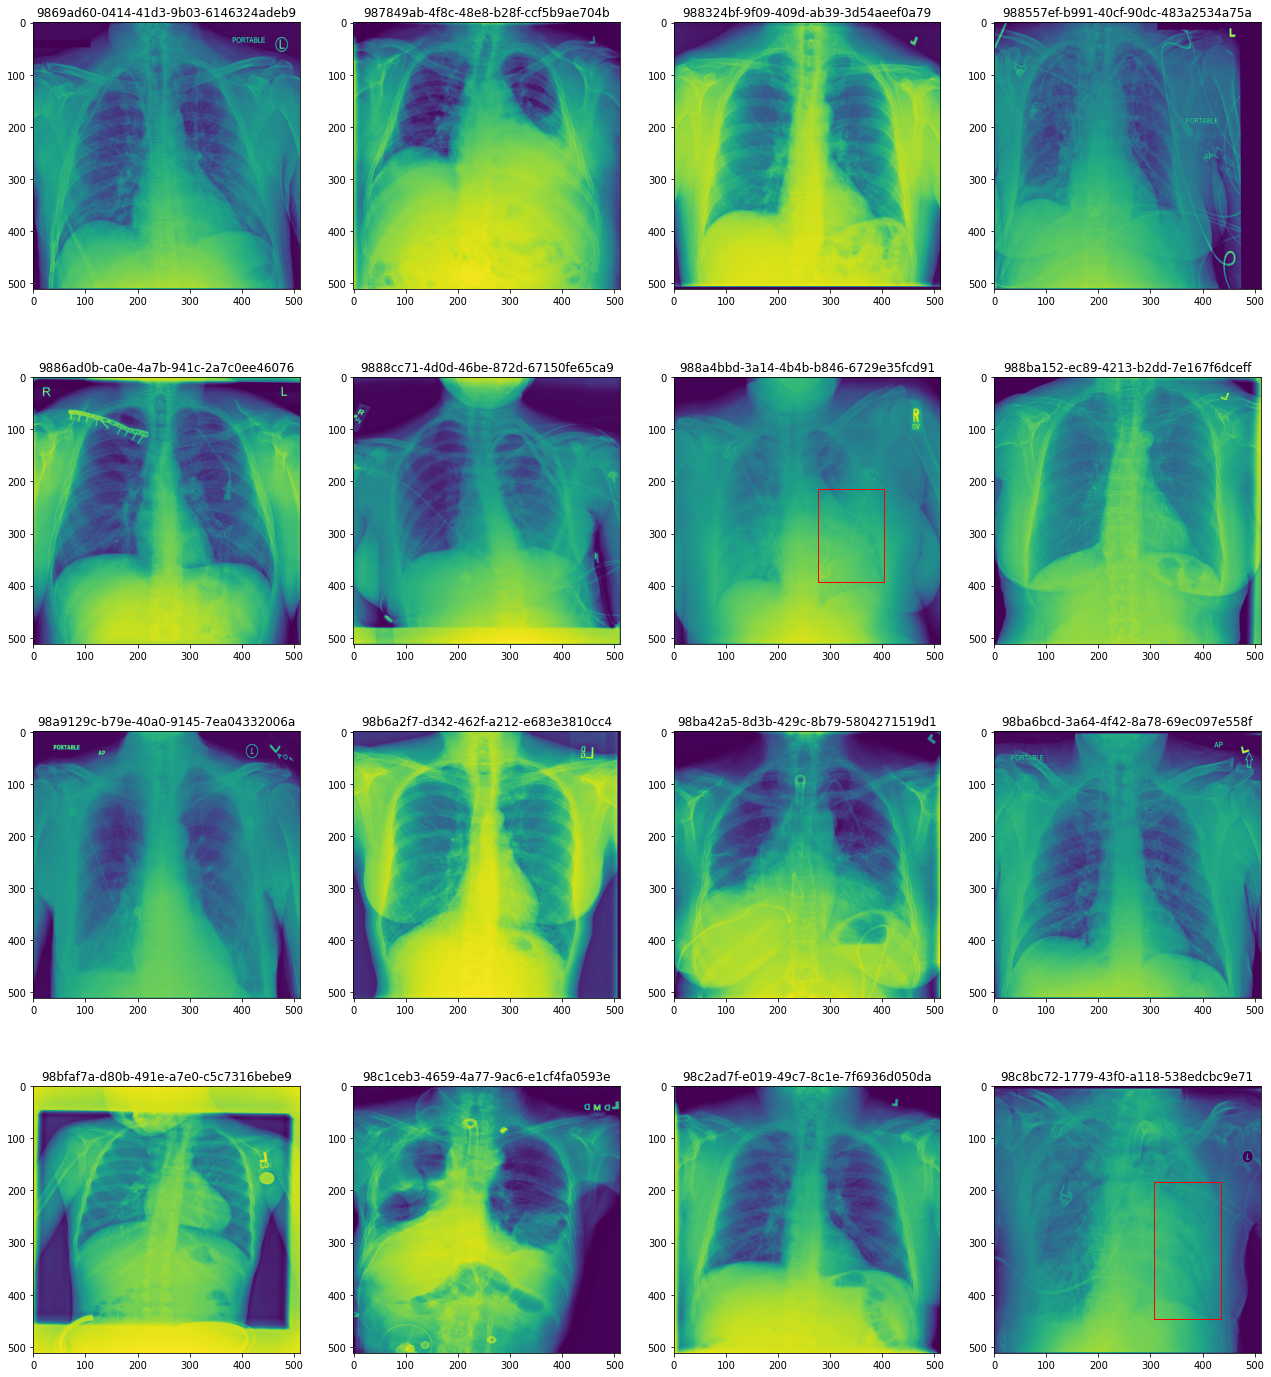

In [20]:
print_samples_with_boxes(test_dataset, 100)